In [2]:
# --- Kaggle starter cell (works on T4) ---

import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim import AdamW           # ✅ use torch.optim.AdamW instead

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report

from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoConfig,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    get_linear_schedule_with_warmup,
    set_seed,
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
set_seed(42)


Device: cuda


In [3]:
# >>>>>>>>>>>>>>>> EDIT THIS <<<<<<<<<<<<<<
# Set your Kaggle input dataset directory here
# Example: "/kaggle/input/bangla-binary-sentiment"
DATA_DIR = "/kaggle/input/bengali-sentiment-classification"

neg_path = os.path.join(DATA_DIR, "all_negative_3307.txt")
pos_path = os.path.join(DATA_DIR, "all_positive_8500.txt")

assert os.path.exists(neg_path), f"neg.txt not found at {neg_path}"
assert os.path.exists(pos_path), f"pos.txt not found at {pos_path}"

def read_txt_lines(fp: str) -> List[str]:
    with open(fp, "r", encoding="utf-8") as f:
        # strip only newline; keep internal spaces/punct
        return [ln.strip() for ln in f.readlines() if ln.strip()]

neg_lines = read_txt_lines(neg_path)
pos_lines = read_txt_lines(pos_path)

print(f"Loaded {len(neg_lines)} negatives, {len(pos_lines)} positives.")

# Build a DataFrame: text + label (0=neg, 1=pos)
df_neg = pd.DataFrame({"text": neg_lines, "label": 0})
df_pos = pd.DataFrame({"text": pos_lines, "label": 1})
df = pd.concat([df_neg, df_pos], ignore_index=True)

# Shuffle for good measure
df = df.sample(frac=1.0, random_state=42).reset_index(drop=True)
print(df.head())
print("Class balance:", df["label"].value_counts().to_dict())


Loaded 3307 negatives, 8500 positives.
                                                text  label
0                                      অসাধারণ লাগলো      1
1       জীবনে প্রথম তানজীন তিশার কোন ভাল নাটক দেখলাম      1
2                                আজাইরা বিষয়বস্তু!!!      0
3  আমাদের দেশের নাটক গুলো ভালো। আর ও ভালো লাগবে ন...      1
4                                   খুব সুন্দর নাটক।      1
Class balance: {1: 8500, 0: 3307}


In [16]:
# --- CELL 3: Dataset Prep (fixed version) ---

# Typical split for ~11K samples: 80% train, 10% val, 10% test
train_df, test_df = train_test_split(df, test_size=0.10, random_state=42, stratify=df["label"])
train_df, val_df  = train_test_split(train_df, test_size=0.1111, random_state=42, stratify=train_df["label"])  # ~10% val

print(len(train_df), len(val_df), len(test_df))

train_ds = Dataset.from_pandas(train_df)
val_ds   = Dataset.from_pandas(val_df)
test_ds  = Dataset.from_pandas(test_df)

# Shared tokenizer from BanglaBERT
TEACHER_NAME = "csebuetnlp/banglabert"
STUDENT_NAME = "sentence-transformers/all-MiniLM-L6-v2"

tokenizer = AutoTokenizer.from_pretrained(TEACHER_NAME)
MAX_LEN = 128

def tokenize_fn(batch):
    return tokenizer(
        batch["text"],
        padding="max_length",
        truncation=True,
        max_length=MAX_LEN
    )

train_ds = train_ds.map(tokenize_fn, batched=True)
val_ds   = val_ds.map(tokenize_fn, batched=True)
test_ds  = test_ds.map(tokenize_fn, batched=True)

# ✅ Ensure consistent column naming
if "label" in train_ds.column_names:
    train_ds = train_ds.rename_column("label", "labels")
    val_ds   = val_ds.rename_column("label", "labels")
    test_ds  = test_ds.rename_column("label", "labels")

# Keep only model-required columns
cols = ["input_ids", "attention_mask", "labels"]
train_ds = train_ds.remove_columns([c for c in train_ds.column_names if c not in cols])
val_ds   = val_ds.remove_columns([c for c in val_ds.column_names if c not in cols])
test_ds  = test_ds.remove_columns([c for c in test_ds.column_names if c not in cols])

train_ds.set_format(type="torch", columns=cols)
val_ds.set_format(type="torch", columns=cols)
test_ds.set_format(type="torch", columns=cols)

# Dataloaders
data_collator = DataCollatorWithPadding(tokenizer)
BATCH_TRAIN = 16
BATCH_EVAL  = 32

train_loader = DataLoader(train_ds, batch_size=BATCH_TRAIN, shuffle=True, collate_fn=data_collator)
val_loader   = DataLoader(val_ds, batch_size=BATCH_EVAL, shuffle=False, collate_fn=data_collator)
test_loader  = DataLoader(test_ds, batch_size=BATCH_EVAL, shuffle=False, collate_fn=data_collator)

print("Columns:", train_ds.column_names)


9445 1181 1181


Map:   0%|          | 0/9445 [00:00<?, ? examples/s]

Map:   0%|          | 0/1181 [00:00<?, ? examples/s]

Map:   0%|          | 0/1181 [00:00<?, ? examples/s]

Columns: ['labels', 'input_ids', 'attention_mask']


In [17]:
# --- CELL 4: Teacher model & training utilities (fixed) ---

teacher_cfg = AutoConfig.from_pretrained(TEACHER_NAME)
teacher_cfg.num_labels = 2
teacher_cfg.output_hidden_states = True

teacher = AutoModelForSequenceClassification.from_pretrained(
    TEACHER_NAME, config=teacher_cfg
).to(device)

# ---- Evaluation helper ----
def run_eval(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in loader:
            labels = batch["labels"].to(device)
            inputs = {k: v.to(device) for k, v in batch.items() if k != "labels"}
            out = model(**inputs)
            preds = out.logits.argmax(dim=-1)
            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())

    acc = accuracy_score(all_labels, all_preds)
    f1_macro = f1_score(all_labels, all_preds, average="macro")
    f1_weighted = f1_score(all_labels, all_preds, average="weighted")
    return {"accuracy": acc, "f1_macro": f1_macro, "f1_weighted": f1_weighted}

# ---- One epoch training helper ----
def train_one_epoch(model, loader, optimizer, scheduler=None, max_grad_norm=1.0):
    model.train()
    total_loss = 0.0
    for batch in loader:
        labels = batch["labels"].to(device)
        inputs = {k: v.to(device) for k, v in batch.items() if k != "labels"}
        out = model(**inputs)
        loss = F.cross_entropy(out.logits, labels)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        if scheduler is not None:
            scheduler.step()
        optimizer.zero_grad()

        total_loss += loss.item()
    return total_loss / max(1, len(loader))


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
from tqdm.auto import tqdm

EPOCHS_TEACHER = 4
lr = 2e-5

num_training_steps = EPOCHS_TEACHER * len(train_loader)
num_warmup_steps = int(0.1 * num_training_steps)

optimizer_t = AdamW(teacher.parameters(), lr=lr)
scheduler_t = get_linear_schedule_with_warmup(
    optimizer_t, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps
)

best_val_f1 = -1
patience = 2
pat_cnt = 0

for epoch in range(1, EPOCHS_TEACHER + 1):
    teacher.train()
    running_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"[Teacher][Epoch {epoch}]", leave=True)
    
    for step, batch in enumerate(progress_bar):
        labels = batch["labels"].to(device)
        inputs = {k: v.to(device) for k, v in batch.items() if k != "labels"}
        out = teacher(**inputs)
        loss = F.cross_entropy(out.logits, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(teacher.parameters(), 1.0)
        optimizer_t.step()
        scheduler_t.step()
        optimizer_t.zero_grad()

        running_loss += loss.item()
        if (step + 1) % 10 == 0:  # update every 10 steps
            progress_bar.set_postfix({
                "batch_loss": f"{loss.item():.4f}",
                "avg_loss": f"{running_loss / (step + 1):.4f}"
            })

    # --- End of epoch evaluation ---
    val_metrics = run_eval(teacher, val_loader)
    print(f"\n[Teacher][Epoch {epoch}] "
          f"avg_train_loss={running_loss / len(train_loader):.4f} | "
          f"val_acc={val_metrics['accuracy']:.4f} | "
          f"val_f1_macro={val_metrics['f1_macro']:.4f} | "
          f"val_f1_weighted={val_metrics['f1_weighted']:.4f}")
    
    # --- Early stopping logic ---
    if val_metrics["f1_macro"] > best_val_f1:
        best_val_f1 = val_metrics["f1_macro"]
        pat_cnt = 0
        teacher_path = "/kaggle/working/teacher_banglabert.pt"
        torch.save(teacher.state_dict(), teacher_path)
        print("  ✅ Saved best teacher:", teacher_path)
    else:
        pat_cnt += 1
        if pat_cnt >= patience:
            print("  ⏹️ Early stopping teacher.")
            break

# --- Final evaluation on test set ---
teacher.load_state_dict(torch.load("/kaggle/working/teacher_banglabert.pt", map_location=device))
teacher.eval()
teacher_test_metrics = run_eval(teacher, test_loader)
print("\n[Teacher][Test Results]")
print(f"Accuracy: {teacher_test_metrics['accuracy']:.4f}")
print(f"Macro F1: {teacher_test_metrics['f1_macro']:.4f}")
print(f"Weighted F1: {teacher_test_metrics['f1_weighted']:.4f}")


[Teacher][Epoch 1]:   0%|          | 0/591 [00:00<?, ?it/s]


[Teacher][Epoch 1] avg_train_loss=0.1161 | val_acc=0.9763 | val_f1_macro=0.9705 | val_f1_weighted=0.9762
  ✅ Saved best teacher: /kaggle/working/teacher_banglabert.pt


[Teacher][Epoch 2]:   0%|          | 0/591 [00:00<?, ?it/s]


[Teacher][Epoch 2] avg_train_loss=0.0682 | val_acc=0.9712 | val_f1_macro=0.9641 | val_f1_weighted=0.9711


[Teacher][Epoch 3]:   0%|          | 0/591 [00:00<?, ?it/s]


[Teacher][Epoch 3] avg_train_loss=0.0324 | val_acc=0.9678 | val_f1_macro=0.9598 | val_f1_weighted=0.9677
  ⏹️ Early stopping teacher.

[Teacher][Test Results]
Accuracy: 0.9644
Macro F1: 0.9558
Weighted F1: 0.9644


In [28]:
from tqdm.auto import tqdm
import torch.nn as nn

# -------------------------------------------------
#  Projection layer to match hidden dimensions
# -------------------------------------------------
# Teacher (BanglaBERT) hidden dim = 768
# Student (MiniLM) hidden dim = 384
proj = nn.Linear(768, 384).to(device)

# ---------------- KD Hyperparameters ----------------
T = 6.0          # temperature
LAMBDA = 0.6     # logit KD weight
ALPHA_FEAT = 0.05  # feature KD weight

# ---------------- Layer mapping ----------------
# Teacher has 12 encoder layers, student has 6
layer_map = {
    1: 2,    # student layer 1 -> teacher layer 2
    3: 6,    # student layer 3 -> teacher layer 6
    5: 10    # student layer 5 -> teacher layer 10
}

# ---------------- KD Loss Function ----------------
def kd_loss_fn(student_out, teacher_out, labels):
    # --- Logit KD ---
    kd_logits = F.kl_div(
        F.log_softmax(student_out.logits / T, dim=-1),
        F.softmax(teacher_out.logits / T, dim=-1),
        reduction="batchmean"
    ) * (T * T)

    # --- Hard CE loss ---
    hard_loss = F.cross_entropy(student_out.logits, labels)

    # --- Hidden-state (feature) KD with projection ---
    feat_loss = 0.0
    for s_idx, t_idx in layer_map.items():
        s_h = student_out.hidden_states[s_idx]                # [B,L,384]
        t_h = proj(teacher_out.hidden_states[t_idx]).detach()  # [B,L,384]
        feat_loss += F.mse_loss(s_h, t_h)
    feat_loss = feat_loss / len(layer_map)

    return (1 - LAMBDA) * hard_loss + LAMBDA * kd_logits + ALPHA_FEAT * feat_loss


# ---------------- Training / Eval Functions ----------------
def train_one_epoch_kd(student, teacher, loader, optimizer, scheduler=None, max_grad_norm=1.0):
    student.train()
    total_loss = 0.0
    progress_bar = tqdm(loader, desc="KD Training", leave=True)

    for step, batch in enumerate(progress_bar):
        labels = batch["labels"].to(device)
        inputs = {k: v.to(device) for k, v in batch.items() if k != "labels"}

        with torch.no_grad():
            t_out = teacher(**inputs)

        s_out = student(**inputs)
        loss = kd_loss_fn(s_out, t_out, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(student.parameters(), max_grad_norm)
        optimizer.step()
        if scheduler is not None:
            scheduler.step()
        optimizer.zero_grad()

        total_loss += loss.item()
        if (step + 1) % 10 == 0:
            progress_bar.set_postfix({
                "batch_loss": f"{loss.item():.4f}",
                "avg_loss": f"{total_loss / (step + 1):.4f}"
            })

    return total_loss / max(1, len(loader))


def eval_model(model, loader) -> Dict[str, float]:
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in loader:
            labels = batch["labels"].to(device)
            inputs = {k: v.to(device) for k, v in batch.items() if k != "labels"}
            out = model(**inputs)
            preds = out.logits.argmax(dim=-1)
            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())
    acc = accuracy_score(all_labels, all_preds)
    f1_macro = f1_score(all_labels, all_preds, average="macro")
    f1_weighted = f1_score(all_labels, all_preds, average="weighted")
    return {"accuracy": acc, "f1_macro": f1_macro, "f1_weighted": f1_weighted}


# ---------------- Student KD Training Loop ----------------
EPOCHS_STUDENT = 10
lr_s = 2e-5

num_training_steps_s = EPOCHS_STUDENT * len(train_loader)
num_warmup_steps_s = int(0.1 * num_training_steps_s)

optimizer_s = AdamW(
    list(student.parameters()) + list(proj.parameters()),  # include projection params
    lr=lr_s
)
scheduler_s = get_linear_schedule_with_warmup(
    optimizer_s, num_warmup_steps=num_warmup_steps_s, num_training_steps=num_training_steps_s
)

best_val_f1_s = -1
patience = 2
pat_cnt = 0

for epoch in range(1, EPOCHS_STUDENT + 1):
    print(f"\n===== [Student KD] Epoch {epoch}/{EPOCHS_STUDENT} =====")
    train_loss = train_one_epoch_kd(student, teacher, train_loader, optimizer_s, scheduler_s)
    val_metrics = eval_model(student, val_loader)

    print(f"[Student][Epoch {epoch}] train_loss={train_loss:.4f} "
          f"val_acc={val_metrics['accuracy']:.4f} "
          f"val_f1_macro={val_metrics['f1_macro']:.4f} "
          f"val_f1_weighted={val_metrics['f1_weighted']:.4f}")

    if val_metrics["f1_macro"] > best_val_f1_s:
        best_val_f1_s = val_metrics["f1_macro"]
        pat_cnt = 0
        student_path = "/kaggle/working/student_minilm_kd.pt"
        torch.save({
            "student_state": student.state_dict(),
            "proj_state": proj.state_dict()
        }, student_path)
        print("  ✅ Saved best student:", student_path)
    else:
        pat_cnt += 1
        if pat_cnt >= patience:
            print("  ⏹️ Early stopping student.")
            break

# ---------------- Final Evaluation on Test ----------------
checkpoint = torch.load("/kaggle/working/student_minilm_kd.pt", map_location=device)
student.load_state_dict(checkpoint["student_state"])
proj.load_state_dict(checkpoint["proj_state"])

student.eval()
student_test_metrics = eval_model(student, test_loader)

print("\n[Student][Test Results]")
print(f"Accuracy: {student_test_metrics['accuracy']:.4f}")
print(f"Macro F1: {student_test_metrics['f1_macro']:.4f}")
print(f"Weighted F1: {student_test_metrics['f1_weighted']:.4f}")



===== [Student KD] Epoch 1/10 =====


KD Training:   0%|          | 0/591 [00:00<?, ?it/s]

[Student][Epoch 1] train_loss=0.2206 val_acc=0.9314 val_f1_macro=0.9126 val_f1_weighted=0.9304
  ✅ Saved best student: /kaggle/working/student_minilm_kd.pt

===== [Student KD] Epoch 2/10 =====


KD Training:   0%|          | 0/591 [00:00<?, ?it/s]

[Student][Epoch 2] train_loss=0.2123 val_acc=0.9229 val_f1_macro=0.9008 val_f1_weighted=0.9214

===== [Student KD] Epoch 3/10 =====


KD Training:   0%|          | 0/591 [00:00<?, ?it/s]

[Student][Epoch 3] train_loss=0.2098 val_acc=0.9289 val_f1_macro=0.9093 val_f1_weighted=0.9278
  ⏹️ Early stopping student.

[Student][Test Results]
Accuracy: 0.9289
Macro F1: 0.9089
Weighted F1: 0.9276


In [29]:
# Save full HF models (config + weights) for deployment
TEACHER_OUT_DIR = "/kaggle/working/teacher_banglabert_hf"
STUDENT_OUT_DIR = "/kaggle/working/student_minilm_kd_hf"

os.makedirs(TEACHER_OUT_DIR, exist_ok=True)
os.makedirs(STUDENT_OUT_DIR, exist_ok=True)

teacher.save_pretrained(TEACHER_OUT_DIR)
student.save_pretrained(STUDENT_OUT_DIR)
tokenizer.save_pretrained(STUDENT_OUT_DIR)  # shared tokenizer

# Rough size print (MB)
def folder_size_mb(path):
    total = 0
    for root, _, files in os.walk(path):
        for f in files:
            total += os.path.getsize(os.path.join(root, f))
    return total / (1024**2)

print("Teacher dir size (MB):", f"{folder_size_mb(TEACHER_OUT_DIR):.2f}")
print("Student dir size (MB):", f"{folder_size_mb(STUDENT_OUT_DIR):.2f}")


Teacher dir size (MB): 422.00
Student dir size (MB): 90.31


Computing alignment:   0%|          | 0/37 [00:00<?, ?it/s]

Computing alignment:   0%|          | 0/37 [00:00<?, ?it/s]


🔍 Teacher–Student Alignment Metrics
Validation → Cosine: 0.0924 | Pearson: 0.1096 | Agreement: 0.5548
Test       → Cosine: 0.1143 | Pearson: 0.1401 | Agreement: 0.5701


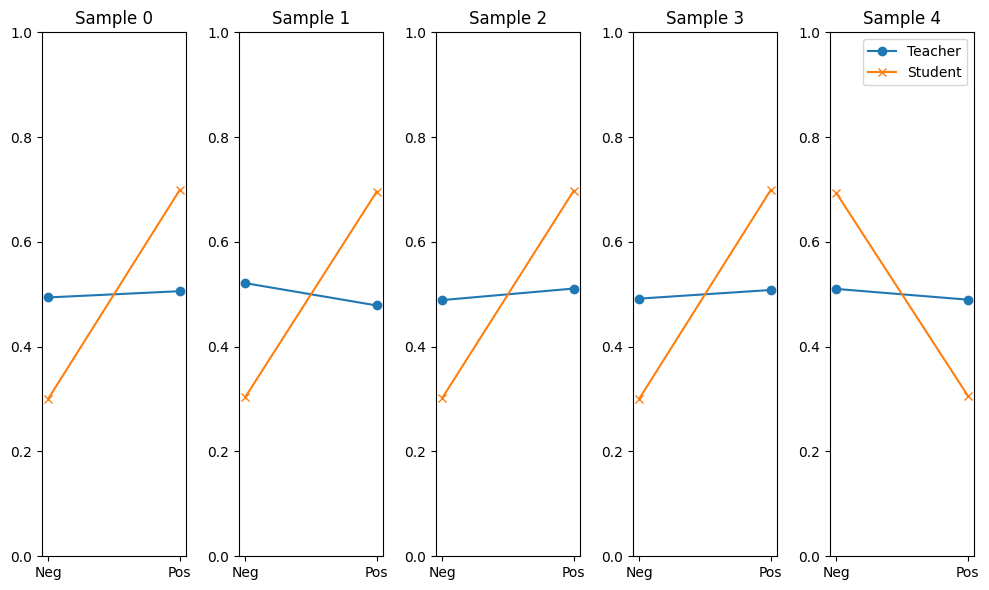

In [30]:
import torch
import torch.nn.functional as F
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# Evaluate teacher–student alignment on validation or test loader
def alignment_metrics(teacher, student, loader, num_batches=50):
    teacher.eval()
    student.eval()

    cos_sims, pearsons, agreements = [], [], []

    with torch.no_grad():
        for i, batch in enumerate(tqdm(loader, desc="Computing alignment")):
            if i >= num_batches:  # limit batches for speed
                break

            labels = batch["labels"].to(device)
            inputs = {k: v.to(device) for k, v in batch.items() if k != "labels"}

            # Get logits
            t_out = teacher(**inputs).logits
            s_out = student(**inputs).logits

            # Flatten for similarity
            t_flat = t_out.detach().cpu().numpy()
            s_flat = s_out.detach().cpu().numpy()

            # 1. Cosine similarity per sample
            cos = F.cosine_similarity(torch.tensor(t_flat), torch.tensor(s_flat), dim=-1).mean().item()
            cos_sims.append(cos)

            # 2. Pearson correlation per sample (teacher vs student logits)
            pvals = []
            for t_vec, s_vec in zip(t_flat, s_flat):
                p = pearsonr(t_vec, s_vec)[0]
                if not np.isnan(p):
                    pvals.append(p)
            pearsons.append(np.mean(pvals))

            # 3. Agreement (same predicted class)
            t_pred = t_out.argmax(dim=-1)
            s_pred = s_out.argmax(dim=-1)
            agree = (t_pred == s_pred).float().mean().item()
            agreements.append(agree)

    metrics = {
        "cosine_mean": np.mean(cos_sims),
        "pearson_mean": np.mean(pearsons),
        "agreement_mean": np.mean(agreements)
    }
    return metrics


# Run alignment check
align_val = alignment_metrics(teacher, student, val_loader)
align_test = alignment_metrics(teacher, student, test_loader)

print("\n🔍 Teacher–Student Alignment Metrics")
print(f"Validation → Cosine: {align_val['cosine_mean']:.4f} | "
      f"Pearson: {align_val['pearson_mean']:.4f} | "
      f"Agreement: {align_val['agreement_mean']:.4f}")
print(f"Test       → Cosine: {align_test['cosine_mean']:.4f} | "
      f"Pearson: {align_test['pearson_mean']:.4f} | "
      f"Agreement: {align_test['agreement_mean']:.4f}")


# ------------------ Optional: Visualize a few batches ------------------
teacher.eval()
student.eval()

batch = next(iter(test_loader))
inputs = {k: v.to(device) for k, v in batch.items() if k != "labels"}

with torch.no_grad():
    t_logits = teacher(**inputs).logits
    s_logits = student(**inputs).logits

t_logits = t_logits.cpu().numpy()
s_logits = s_logits.cpu().numpy()

# Plot for the first 5 samples
plt.figure(figsize=(10, 6))
for i in range(min(5, len(t_logits))):
    plt.subplot(1, 5, i + 1)
    plt.plot(F.softmax(torch.tensor(t_logits[i]), dim=-1), label="Teacher", marker="o")
    plt.plot(F.softmax(torch.tensor(s_logits[i]), dim=-1), label="Student", marker="x")
    plt.title(f"Sample {i}")
    plt.xticks([0, 1], ["Neg", "Pos"])
    plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()
